<a href="https://colab.research.google.com/github/s-c-soma/AdvanceDeeplearning-CMPE-297/blob/master/Assignment_1_%20Part_2/Assignment_2d_MixMatch_Semi_Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D - MixMatch semi supervised classification 

# Implementation Details and Discussion

**Semi-supervised** is an machine learning approach that deals with both label and unlabeled data. The amount of labeled data is very less compared to unlabeled data. So Semi-supervised learning belongs to both unsupervised and supervised learning

**Mixmatch** technique uses is a part of Semi-supervised learning and includes the 3 paradigms of SSL. Previously these approaches were being used seperately. The approache is used by augmenting both the labeled and unlabeled traning set. Consistency regularization, entropy minimization and traditional regularization are being blended for this approach

**Implementation**

In my following implementation I have used two datasets. Part 1 contains the CIFAR dataset and part-2 contains Mnist dataset. For the submission I have minimized the number of epochs, so that the colab can be run again if needed. Following section contains the steps of the algorithm that is being followed in every step of implementation. The accuracy with the Cifar dataset is higher compared to Mnist dataset.

**The Mixmatch Algorithm**
> This Mixmatch algorithim combines the following steps for implementation. 

* 1. Training data is supplied with labeled and unlabeled data
* 2. Then labeled batch is augmented to produce a new training batch
* 3. I have augmented each image in the unlabeled batch for $K$ times to produce new unlabeled batch of total $BatchSize * K$
* 4. Then for each normal image in the unlabeled batch, $K$ augmented images are passed to the model for training. Then the average of the model's prediction is computed to generate a pseudo-label for augmented images
* 5. The I have sharpened the the psedu-label images
* 6. Combining the augmented labeled images and it's labels, a new dataset is formed called $S$. $U$ is the set of augmented unlabeled images and its predicted labels. 
* 7. Now I have concatenated both the sets $S$ and $U$ and formed a new set called $W$ after shuffling.
* 8. After that I have a formed a set $S'$ by applying mixup augmentation process to sets $S$ and $|S|$ from $W$. This process is implmented seperately for two datasets.
* 9. Set $U'$ is formed by applying mixup augmentation to sets $U$ and rest of the elements of $W$ 

Finally $S'$ (labeled mixup) and $U'$ (unlabeled mixup) are passed to the netwprk model for prediction. The computed loss using mixed-up labels is shown below for each dataset


In [ ]:
#Importing fastai will also import numpy, pytorch, etc. 
from fastai.vision import *
from numbers import Integral
import seaborn as sns


from sklearn.datasets import make_moons, make_blobs, make_circles, make_classification
import pdb
import contextlib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Part 1 - Using Cifar Dataset

## Data Augmentation

In [ ]:
#Modified from 
K=2
class MultiTransformLabelList(LabelList):
    def __getitem__(self,idxs:Union[int,np.ndarray])->'LabelList':
        "return a single (x, y) if `idxs` is an integer or a new `LabelList` object if `idxs` is a range."
        idxs = try_int(idxs)
        if isinstance(idxs, Integral):
            if self.item is None: x,y = self.x[idxs],self.y[idxs]
            else:                 x,y = self.item   ,0
            if self.tfms or self.tfmargs:
                #I've changed this line to return a list of augmented images
                x = [x.apply_tfms(self.tfms, **self.tfmargs) for _ in range(K)]
            if hasattr(self, 'tfms_y') and self.tfm_y and self.item is None:
                y = y.apply_tfms(self.tfms_y, **{**self.tfmargs_y, 'do_resolve':False})
            if y is None: y=0
            return x,y
        else: return self.new(self.x[idxs], self.y[idxs])
        
#I'll also need to change the default collate function to accomodate multiple augments
def MixmatchCollate(batch):
    batch = to_data(batch)
    if isinstance(batch[0][0],list):
        batch = [[torch.stack(s[0]),s[1]] for s in batch]
    return torch.utils.data.dataloader.default_collate(batch)

In [ ]:
#Grab file path to cifar dataset. Will download data if not present
path = untar_data(URLs.CIFAR)

#Custom ImageList with filter function
class MixMatchImageList(ImageList):
    def filter_train(self,num_items,seed=2343):
        train_idxs = np.array([i for i,o in enumerate(self.items) if Path(o).parts[-3] != "test"])
        valid_idxs = np.array([i for i,o in enumerate(self.items) if Path(o).parts[-3] == "test"])
        np.random.seed(seed)
        keep_idxs = np.random.choice(train_idxs,num_items,replace=False)
        self.items = np.array([o for i,o in enumerate(self.items) if i in np.concatenate([keep_idxs,valid_idxs])])
        return self
    
#Create two databunch objects for the labeled and unlabled images using fastai
data_labeled = (MixMatchImageList.from_folder(path)
                .filter_train(500) #Use 500 labeled images for traning
                .split_by_folder(valid="test") #test on all 10000 images in test set
                .label_from_folder()
                .transform(get_transforms(),size=32)
                # num_workers=0 for a potential performance improvement
                .databunch(bs=64,num_workers=0)
                .normalize(cifar_stats))

train_set = set(data_labeled.train_ds.x.items)
src = (ImageList.from_folder(path)
        .filter_by_func(lambda x: x not in train_set)
        .split_by_folder(valid="test"))
src.train._label_list = MultiTransformLabelList
data_unlabeled = (src.label_from_folder()
         .transform(get_transforms(),size=32)
         .databunch(bs=128,collate_fn=MixmatchCollate,num_workers=0)
         .normalize(cifar_stats))

#Databunch with all 50k images labeled, for baseline
data_full = (ImageList.from_folder(path)
        .split_by_folder(valid="test")
        .label_from_folder()
        .transform(get_transforms(),size=32)
        .databunch(bs=128,num_workers=0)
        .normalize(cifar_stats))

## Mixup

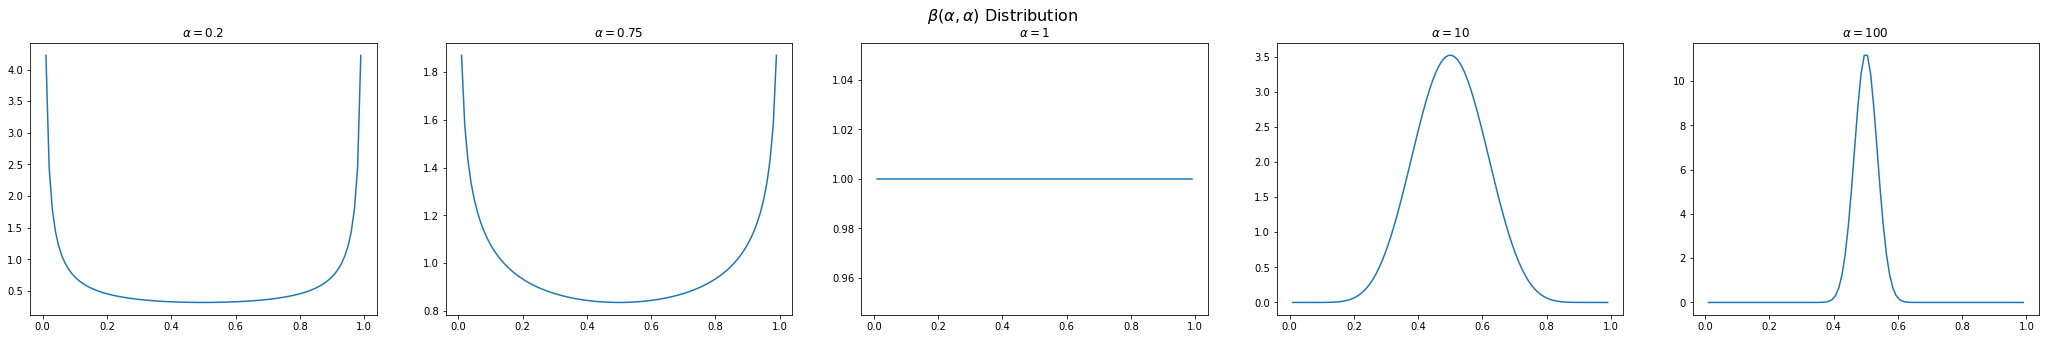

In [ ]:
from scipy.stats import beta
x = np.linspace(0.01,0.99, 100)
fig, axes = plt.subplots(1,5,figsize=(36,5))
fig.suptitle(r"$\beta(\alpha,\alpha)$ Distribution",fontsize=16)
alphas = [0.2,0.75,1,10,100]
for a, ax in zip(alphas,axes.flatten()):
    ax.set_title(r"$\alpha={}$".format(a))
    ax.plot(x, beta.pdf(x, a, a))

In [ ]:
def mixup(a_x,a_y,b_x,b_y,alpha=0.75):
    l = np.random.beta(alpha,alpha)
    l = max(l,1-l)
    x = l * a_x + (1-l) * b_x
    y = l* a_y + (1-l) * b_y
    return x,y

## Sharpening

In [ ]:
def sharpen(p,T=0.5):
    u = p ** (1/T)
    return u / u.sum(dim=1,keepdim=True)

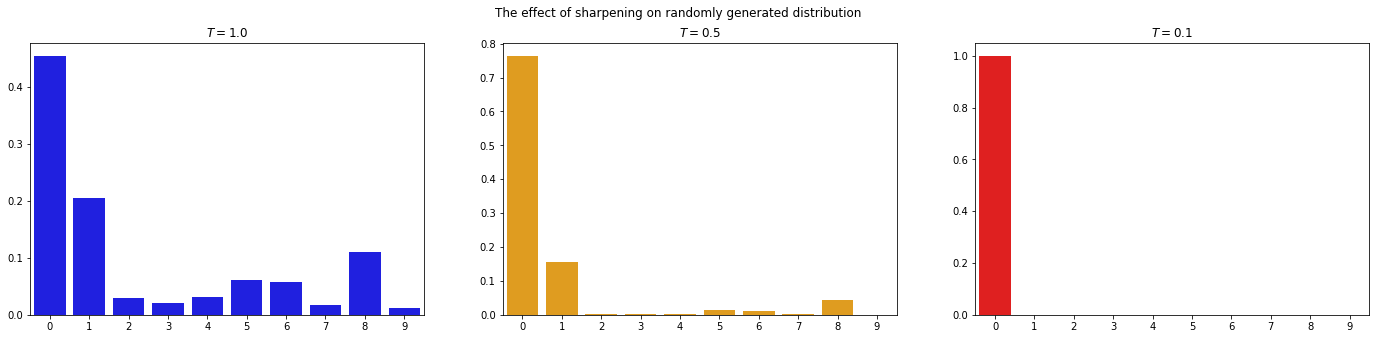

In [ ]:
a = torch.softmax(torch.randn(10),0)
fig, axes = plt.subplots(1,3,figsize=(24,5))
fig.suptitle("The effect of sharpening on randomly generated distribution")
sns.barplot(x=np.arange(10),y=a,color="blue",ax=axes[0])
axes[0].set_title("$T = 1.0$")
sns.barplot(x=np.arange(10),y=sharpen(a[None,:],0.5)[0],color="orange",ax=axes[1])
axes[1].set_title("$T = 0.5$")
sns.barplot(x=np.arange(10),y=sharpen(a[None,:],0.1)[0],color="red",ax=axes[2])
axes[2].set_title("$T = 0.1$");

## Building Model

In [ ]:
model = models.WideResNet(num_groups=3,N=4,num_classes=10,k=2,start_nf=32)

## Loss

In [ ]:
class MixupLoss(nn.Module):
    def forward(self, preds, target, unsort=None, ramp=None, bs=None):
        if unsort is None:
            return F.cross_entropy(preds,target)
        preds = preds[unsort]
        preds_l = preds[:bs]
        preds_ul = preds[bs:]
        preds_l = torch.log_softmax(preds_l,dim=1)
        preds_ul = torch.softmax(preds_ul,dim=1)
        loss_x = -(preds_l * target[:bs]).sum(dim=1).mean()
        loss_u = F.mse_loss(preds_ul,target[bs:])
        self.loss_x = loss_x.item()
        self.loss_u = loss_u.item()
        return loss_x + 100 * ramp * loss_u

## Training

Training the models using mixmatch labels

In [ ]:
class MixMatchTrainer(LearnerCallback):
    _order=-20
    def on_train_begin(self, **kwargs):
        self.l_dl = iter(data_labeled.train_dl)
        self.smoothL, self.smoothUL = SmoothenValue(0.98), SmoothenValue(0.98)
        self.recorder.add_metric_names(["l_loss","ul_loss"])
        self.it = 0
        
    def on_batch_begin(self, train, last_input, last_target, **kwargs):
        if not train: return
        try:
            x_l,y_l = next(self.l_dl)
        except:
            self.l_dl = iter(data_labeled.train_dl)
            x_l,y_l = next(self.l_dl)
            
        x_ul = last_input
        
        with torch.no_grad():
            ul_labels = sharpen(torch.softmax(torch.stack([self.learn.model(x_ul[:,i]) for i in range(x_ul.shape[1])],dim=1),dim=2).mean(dim=1))
            
        x_ul = torch.cat([x for x in x_ul])
        ul_labels = torch.cat([y.unsqueeze(0).expand(K,-1) for y in ul_labels])
        
        l_labels = torch.eye(data_labeled.c).cuda()[y_l]
        
        w_x = torch.cat([x_l,x_ul])
        w_y = torch.cat([l_labels,ul_labels])
        idxs = torch.randperm(w_x.shape[0])
        
        mixed_input, mixed_target = mixup(w_x,w_y,w_x[idxs],w_y[idxs])
        bn_idxs = torch.randperm(mixed_input.shape[0])
        unsort = [0] * len(bn_idxs)
        for i,j in enumerate(bn_idxs): unsort[j] = i
        mixed_input = mixed_input[bn_idxs]
    

        ramp = self.it / 3000.0 if self.it < 3000 else 1.0
        return {"last_input": mixed_input, "last_target": (mixed_target,unsort,ramp,x_l.shape[0])}
    
    def on_batch_end(self, train, **kwargs):
        if not train: return
        self.smoothL.add_value(self.learn.loss_func.loss_x)
        self.smoothUL.add_value(self.learn.loss_func.loss_u)
        self.it += 1

    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics,[self.smoothL.smooth,self.smoothUL.smooth])

In [ ]:
learn = Learner(data_unlabeled,model,loss_func=MixupLoss(),callback_fns=[MixMatchTrainer],metrics=accuracy)

## Results

In [ ]:
learnFS = Learner(data_full,models.WideResNet(num_groups=3,N=4,num_classes=10,k=2,start_nf=32),metrics=accuracy)
# learnFS.fit_one_cycle(100,2e-2,wd=1e-4)
learnFS.fit_one_cycle(10,2e-2,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.211738,1.799919,0.450500,01:52
1,0.938703,0.995341,0.657200,01:51
2,0.761930,0.797271,0.733100,01:51
3,0.618178,0.700240,0.771900,01:51
4,0.519543,0.545449,0.816100,01:51
5,0.421758,0.498815,0.836200,01:51
6,0.342447,0.398741,0.868900,01:51
7,0.275596,0.347749,0.887200,01:51
8,0.238292,0.288381,0.904800,01:51
9,0.211121,0.291114,0.903900,01:50


training on just the 500 labeled images, with no unsupervised component

In [ ]:
learnBase = Learner(data_labeled,models.WideResNet(num_groups=3,N=4,num_classes=10,k=2,start_nf=32),metrics=accuracy)
# learnBase.fit_one_cycle(50,2e-2,wd=1e-4)
learnBase.fit_one_cycle(5,2e-2,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.221369,67.991249,0.103000,00:06
1,2.228044,337.835846,0.157500,00:06
2,2.176858,107.192009,0.103800,00:06
3,2.131333,2.325347,0.200400,00:06
4,2.077936,2.072614,0.222500,00:06


Finally I will train with MixMatch, using the learner defined in the previous section. Note that I now use learn.fit instead of learn.fit_one_cycle since MixMatch uses EMA instead of a learning rate schedule.

In [ ]:
#learn.fit_one_cycle(200,2e-3,wd=0.02)
learn.fit_one_cycle(2,2e-3,wd=0.02)

epoch,train_loss,valid_loss,accuracy,l_loss,ul_loss,time
0,1.433029,1.441749,0.515000,1.305534,0.011310,04:12
1,1.199887,1.391736,0.559100,0.937609,0.010901,04:13


# Part 2 - Using Mnist Dataset

## Load MNIST DATA

In [ ]:
path = untar_data(URLs.MNIST)

## MixMatch Function:

This code is to make custom 

In [ ]:
class MixMatchImageList(ImageList):
    def filter_train(self,num_items,seed=2343):
        train_idxs = np.array([i for i,o in enumerate(self.items) if Path(o).parts[-3] != "testing"])
        valid_idxs = np.array([i for i,o in enumerate(self.items) if Path(o).parts[-3] == "testing"])
        np.random.seed(seed)
        keep_idxs = np.random.choice(train_idxs,num_items,replace=False)
        self.items = np.array([o for i,o in enumerate(self.items) if i in np.concatenate([keep_idxs,valid_idxs])])
        return self

In [ ]:
data = (MixMatchImageList.from_folder(path)
        .filter_train(500)
        .split_by_folder(train="training",valid="testing")
        .label_from_folder()
        .databunch(bs=64))

dataFull = (ImageList.from_folder(path)
            .split_by_folder(train="training",valid="testing")
            .label_from_folder()
            .databunch(bs=128))

## Basic Network 

In [ ]:
class BasicNN(nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,64,3,2,1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,128,3,2,1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128))
        self.out = nn.Linear(128,num_classes)
        
    def forward(self, x, noise=True):
        x = self.conv(x)
        x = F.adaptive_avg_pool2d(x,1).view(-1,128)
        return self.out(x)

## Sharpening Image

In [ ]:
def sharpen(p,T=0.5):
    u = p ** (1/T)
    return u / u.sum(dim=1,keepdim=True)

## Model and Loss

In [ ]:
class EntropyMinTrainer(LearnerCallback):
    def __init__(self, learn, T=0.5):
        super().__init__(learn)
        self.T = T
        
    def on_train_begin(self, **kwargs):
        self.l_dl = iter(data.train_dl)
        self.it = 0
        
    def on_batch_begin(self, train, last_input, **kwargs):
        if not train: return 
        with torch.no_grad():
            ul_labels = sharpen(torch.softmax(self.learn.model(last_input),dim=1),T=self.T)
            #ul_labels = torch.softmax(self.learn.model(*last_input),dim=1)
        
        self.it += 1
        ramp = self.it / 800.0 if self.it < 800 else 1.0
        return {"last_target": (ul_labels,ramp)}
    
    def on_backward_begin(self, last_loss, last_output, **kwargs):
        try:
            l_x,l_y = next(self.l_dl)
        except:
            self.l_dl = iter(data.train_dl)
            l_x,l_y = next(self.l_dl)
            
        real_preds = self.learn.model(l_x)
        real_loss = F.cross_entropy(real_preds,l_y)
        return {"last_loss": last_loss + real_loss}
    
def entropy_min_loss(preds,target,ramp=None):
    if ramp is None:
        return F.cross_entropy(preds,target)
    preds = torch.softmax(preds,dim=1)
    return 10.0 * ramp * F.mse_loss(preds,target)
    #p = torch.softmax(preds,dim=1)
    #return -(p * torch.log(p)).sum(dim=1).mean()
    #d = torch.distributions.Categorical(torch.softmax(preds,dim=1))
    #return d.entropy().mean()

## Training

In [ ]:
learn = Learner(dataFull,BasicNN(),loss_func=entropy_min_loss,callback_fns=[EntropyMinTrainer],metrics=accuracy)

In [ ]:
learn.fit_one_cycle(10,3e-3,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.034829,0.950018,0.731000,00:21
1,0.018226,0.531585,0.846000,00:21
2,0.007797,0.687884,0.842900,00:21
3,0.005133,0.539591,0.892300,00:21
4,0.003807,0.552718,0.895700,00:22
5,0.003210,0.664921,0.893000,00:21
6,0.002382,0.580173,0.910700,00:21
7,0.002319,0.577765,0.911900,00:21
8,0.002098,0.564102,0.917200,00:21
9,0.001773,0.572752,0.916200,00:21


In [ ]:
learn2 = Learner(dataFull,BasicNN(),loss_func=entropy_min_loss,callback_fns=[partial(EntropyMinTrainer,T=1.0)],metrics=accuracy)

In [ ]:
learn2.fit_one_cycle(10,3e-3,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.000000,1.037645,0.702800,00:21
1,0.000000,0.665148,0.780800,00:21
2,0.000000,0.725410,0.782100,00:21
3,0.000000,0.596453,0.821200,00:21
4,0.000000,0.653629,0.815000,00:21
5,0.000000,0.697675,0.821300,00:22
6,0.000000,0.753799,0.818000,00:21
7,0.000000,0.793894,0.822100,00:22
8,0.000000,0.838714,0.814900,00:22
9,0.000000,0.834294,0.815400,00:22


## Results

In [ ]:
digits, preds, pred_labels, labels = [], [], [], []
preds2, pred_labels2, = [], []
l = torch.eye(10).byte().cuda()
learn.model.eval()
learn2.model.eval()
with torch.no_grad():
    for x,y in progress_bar(iter(dataFull.valid_dl),total=len(dataFull.valid_dl)):
        p = learn.model(x).detach()
        p = torch.softmax(p,dim=1)
        p_a = torch.argmax(p,dim=1)
        preds.append(p.masked_select(l[p_a]))
        pred_labels.append(p_a)
        labels.append(y)
        digits.append(x[:,0].view(-1,28*28))
        
        p = learn2.model(x).detach()
        p = torch.softmax(p,dim=1)
        p_a = torch.argmax(p,dim=1)
        preds2.append(p.masked_select(l[p_a]))
        pred_labels2.append(p_a)

labels = torch.cat(labels)
digits = torch.cat(digits)
preds = torch.cat(preds)
pred_labels = torch.cat(pred_labels)
preds2 = torch.cat(preds2)
pred_labels2 = torch.cat(pred_labels2)
(pred_labels == labels).float().mean(), (pred_labels2 == labels).float().mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)


(tensor(0.9162, device='cuda:0'), tensor(0.8154, device='cuda:0'))